<a href="https://colab.research.google.com/github/shraddha-an/nn-practice/blob/main/car_price_regression_nns.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Predicting Car Prices with Regression Neural Network**

## **1) Importing libraries**

In [18]:
# Importing required libraries
# Data Handling/ Manipulation
import pandas as pd
import numpy as np

# Torch
import torch
import torch.nn as nn, torch.nn.functional as F

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Time 
import time
from datetime import datetime as dt

# Plotting
import matplotlib.pyplot as plt
import seaborn as sb

In [19]:
# Importing the dataset
dataset = pd.read_csv('car_data.csv')
print(dataset.info(),'\n\n')
dataset.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301 entries, 0 to 300
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Car_Name       301 non-null    object 
 1   Year           301 non-null    int64  
 2   Selling_Price  301 non-null    float64
 3   Present_Price  301 non-null    float64
 4   Kms_Driven     301 non-null    int64  
 5   Fuel_Type      301 non-null    object 
 6   Seller_Type    301 non-null    object 
 7   Transmission   301 non-null    object 
 8   Owner          301 non-null    int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 21.3+ KB
None 




,Car_Name,Year,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner
0,ritz,2014,3.35,5.59,27000,Petrol,Dealer,Manual,0
1,sx4,2013,4.75,9.54,43000,Diesel,Dealer,Manual,0
2,ciaz,2017,7.25,9.85,6900,Petrol,Dealer,Manual,0
3,wagon r,2011,2.85,4.15,5200,Petrol,Dealer,Manual,0
4,swift,2014,4.60,6.87,42450,Diesel,Dealer,Manual,0


## **2) Data Preprocessing**
---
**Steps:**

1) Columns to encode: Fuel_Type, Seller_Type, Transmission

2) Feature Extraction: Extract Age of the vehicle from the Year column

3) Columns to delete: Car_Name, Year.






In [20]:
# Calculating age in years of each vehicle
%time
dataset['Age'] = dataset['Year'].apply(lambda x: dt.today().year - x)

# Deleting car name & year columns
dataset.drop(columns = ['Car_Name', 'Year'], inplace = True)

# Splitting into feature & target matrices
X = dataset.iloc[:, 1:].values
y = dataset.iloc[:, 0].values.reshape(-1, 1)

# Splitting into train & test subsets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0, test_size = 0.2)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 6.68 µs


((240, 7), (240, 1), (61, 7), (61, 1))

In [21]:
# Label Encoding
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer 

enc = LabelEncoder()

X_train[:, 2] = enc.fit_transform(X_train[:, 2])
X_test[:, 2] = enc.transform(X_test[:, 2])

X_train[:, 3] = enc.fit_transform(X_train[:, 3])
X_test[:, 3] = enc.transform(X_test[:, 3])

X_train[:, 4] = enc.fit_transform(X_train[:, 4])
X_test[:, 4] = enc.transform(X_test[:, 4])

# OHE the fuel_type column
ohe = ColumnTransformer([('encoder', OneHotEncoder(), [2])], remainder = 'passthrough') 

X_train = ohe.fit_transform(X_train)
X_test = ohe.transform(X_test)

# Standardization
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()

X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

len(X_test[0])

9

In [22]:
len(X_train[0])

9

## **3) PyTorch Neural Network**

In [23]:
# Converting numpy arrays to torch tensors of dtype float32
%time
from torch.utils.data import TensorDataset, DataLoader, RandomSampler

train_data = TensorDataset(torch.tensor(X_train, dtype = torch.float32), torch.tensor(y_train, dtype = torch.float32))
test_data = TensorDataset(torch.tensor(X_test, dtype = torch.float32), torch.tensor(y_test, dtype = torch.float32))

# Creating data loader objects that'll supply batches of data to our model
train = DataLoader(dataset = train_data, sampler = RandomSampler(train_data), batch_size = 16)
test = DataLoader(dataset = test_data, batch_size = 1)

CPU times: user 1e+03 ns, sys: 0 ns, total: 1e+03 ns
Wall time: 5.01 µs


In [24]:
# Defining the Regression Neural Network: 1 input layer, 1 hidden layer, 1 output layer
%time
class RegressionNN(nn.Module):
  # Defining our neural network architecture in the constructor 
  def __init__(self, input_dim):
    # Calling the correct parent constructors
    super().__init__()

    self.input1 = nn.Linear(in_features = input_dim, out_features = 100)
    self.hidden2 = nn.Linear(in_features = 100, out_features = 200)
    self.output3 = nn.Linear(in_features = 200, out_features = 1)

  # Defining forward pass computations
  def forward(self, x):
    x = F.relu(self.input1(x))
    x = F.relu(self.hidden2(x))
    x = self.output3(x)

    return x

# Creating an object of our neural network class
input_dim = len(X_train[0])
model = RegressionNN(input_dim = input_dim)
print(model)


CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.01 µs
RegressionNN(
  (input1): Linear(in_features=9, out_features=100, bias=True)
  (hidden2): Linear(in_features=100, out_features=200, bias=True)
  (output3): Linear(in_features=200, out_features=1, bias=True)
)


In [26]:
# Optimizer
from torch.optim import Adam

optimizer = Adam(params = model.parameters(), lr = 0.02, eps = 2e-3, amsgrad = True)

# Loss Function
criterion = nn.L1Loss()

In [27]:
# Training loop
%time

# Putting model in train mode
model.train()

# Epochs 
epochs = 20

for epoch in range(epochs):
  print('\nEpoch {}/{}'.format(epoch + 1, epochs))
  print('------------')

  # Calculating training loss for every epoch
  train_loss = 0.0

  # Training batches
  for features, target in train:
    
    # Push variables to device
    features, target = features.to(device), target.to(device)

    # Clear out gradients from previous training batch
    optimizer.zero_grad()

    # Forward pass; feed inputs to model & get outputs
    outputs = model(features)

    # Calculate loss between model's predictions & actual target
    loss = criterion(outputs, target)
    train_loss += loss.item()

    # Back propagate loss throughout the neural network
    loss.backward()

    # Update parameters based on the current gradient
    optimizer.step()
  
  print('Training Loss: ', train_loss/len(train))

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.77 µs

Epoch 1/20
------------
Training Loss:  2.068154462178548

Epoch 2/20
------------
Training Loss:  1.0573055803775788

Epoch 3/20
------------
Training Loss:  0.7986886064211528

Epoch 4/20
------------
Training Loss:  0.9400634328524272

Epoch 5/20
------------
Training Loss:  0.7415276765823364

Epoch 6/20
------------
Training Loss:  0.7987392942110697

Epoch 7/20
------------
Training Loss:  0.7416189769903819

Epoch 8/20
------------
Training Loss:  0.8328844587008158

Epoch 9/20
------------
Training Loss:  0.7702595790227255

Epoch 10/20
------------
Training Loss:  0.6891183078289032

Epoch 11/20
------------
Training Loss:  0.6810120304425558

Epoch 12/20
------------
Training Loss:  0.7637466013431549

Epoch 13/20
------------
Training Loss:  0.8400286654631297

Epoch 14/20
------------
Training Loss:  0.6791154424349467

Epoch 15/20
------------
Training Loss:  0.7529909491539002

Epoch 16/20
------------
Train

In [28]:
# Testing loop
%time

# Variables to track predictions & target
preds, targets = [], []

# Putting model in test mode
model.eval()

# Disabling gradient calculation with no_grad(). Deactivates auto_grad engine 
# and reduces memory usage and speeds up computations but back propagation not possible.
with torch.no_grad():
  for features, target in test:

    # Pushing data to the device
    features = features.to(device)

    # Perform forward pass, collect outputs
    output = model(features)

    # Deatch predictions from the graph and append to list
    preds.append(output.detach().cpu().numpy())
    targets.append(target.to('cpu').numpy())

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.01 µs


In [29]:
# Converting preds to a simple list from a list of arrays
preds = [x[0][0] for x in preds]
y_test = [x for x in y_test]

# Calculating MAE & MSE between predictions & target
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(y_test, preds)
mse = mean_squared_error(y_test, preds)

print('Mean Absolute Error: {}\nMean Squared Error: {}'.format(mae, mse) )

Mean Absolute Error: 0.7644213316284243
Mean Squared Error: 1.4707236087478457


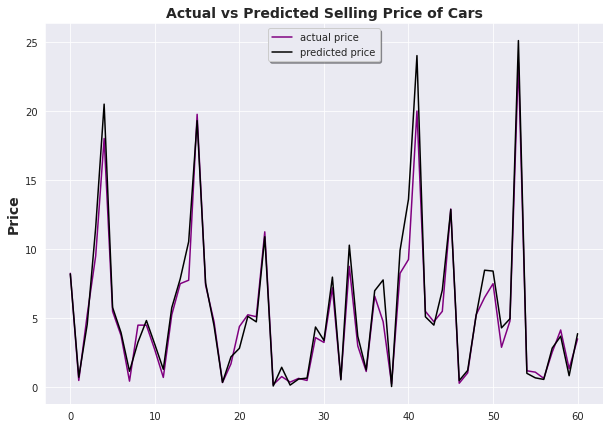

In [30]:
# Plotting the target variable
sb.set_style('darkgrid')
plt.figure(figsize = (10, 7))

plt.plot(y_test, color = 'purple', label = 'actual price')
plt.plot(preds, color = 'black', label = 'predicted price')
plt.legend(shadow = True, loc = 'upper center')
plt.title('Actual vs Predicted Selling Price of Cars', fontsize = 14, fontweight = 'semibold')
plt.ylabel('Price', fontsize = 14, fontweight = 'semibold')
plt.show()

## **4) Keras Neural Network**

In [31]:
# Importing keras modules
from keras.models import Sequential
from keras.layers import Dense

regressor = Sequential()
regressor.add(Dense(units = 100, activation = 'relu', input_dim = input_dim))
regressor.add(Dense(units = 200, activation = 'relu'))
regressor.add(Dense(units = 1))

# Compiling the model with adam optimizer
regressor.compile(optimizer = 'adam', metrics = ['mean_squared_error'], loss = 'mean_squared_logarithmic_error')

# Training the model
history = regressor.fit(X_train, y_train, batch_size = 16, epochs = 20, verbose = 0)

# Evaluating on test set
y_pred = regressor.predict(X_test)

# Printing metrics
mae_k = mean_absolute_error(y_test, y_pred)
mse_k = mean_squared_error(y_test, y_pred)

print('MAE: {}\nMSE: {}'.format(mae_k, mse_k))

MAE: 0.6864358898948449
MSE: 1.184681162771141
